In [1]:
print("h")

h


In [2]:
import torch
from diffusers import SanaPipeline

pipe = SanaPipeline.from_pretrained(
    "Efficient-Large-Model/Sana_1600M_1024px_diffusers",
    #"Efficient-Large-Model/Sana_600M_1024px_diffusers",
    variant="fp16",
    torch_dtype=torch.float16,
)
pipe.to("cuda")

pipe.vae.to(torch.bfloat16)
pipe.text_encoder.to(torch.bfloat16)



/home/galkesten/miniconda3/envs/sana/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/home/galkesten/miniconda3/envs/sana/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Gemma2Model(
  (embed_tokens): Embedding(256000, 2304, padding_idx=0)
  (layers): ModuleList(
    (0-25): 26 x Gemma2DecoderLayer(
      (self_attn): Gemma2Attention(
        (q_proj): Linear(in_features=2304, out_features=2048, bias=False)
        (k_proj): Linear(in_features=2304, out_features=1024, bias=False)
        (v_proj): Linear(in_features=2304, out_features=1024, bias=False)
        (o_proj): Linear(in_features=2048, out_features=2304, bias=False)
        (rotary_emb): Gemma2RotaryEmbedding()
      )
      (mlp): Gemma2MLP(
        (gate_proj): Linear(in_features=2304, out_features=9216, bias=False)
        (up_proj): Linear(in_features=2304, out_features=9216, bias=False)
        (down_proj): Linear(in_features=9216, out_features=2304, bias=False)
        (act_fn): PytorchGELUTanh()
      )
      (input_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
      (pre_feedforward_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
      (post_feedforward_layernorm): Gemma2RMSNorm((2304,),

In [3]:
def debug_callback_on_step_end(pipeline, step, timestep, callback_kwargs):
    latents = callback_kwargs["latents"]
    prompt_embeds = callback_kwargs["prompt_embeds"]
    negative_prompt_embeds = callback_kwargs["negative_prompt_embeds"]

    print(f"[Step {step}] Timestep: {timestep}")
    print(f"Latents shape: {latents.shape}")
    # print(f"Prompt embeds shape: {prompt_embeds.shape}")
    # if negative_prompt_embeds is not None:
    #     print(f"Negative prompt embeds shape: {negative_prompt_embeds.shape}")
    return {
        "latents": latents,
        "prompt_embeds": prompt_embeds,
        "negative_prompt_embeds": negative_prompt_embeds,
    }


In [4]:
def print_shape_hook(name):
    def hook(module, input, output):
        print(f"name: {name}")
        print(type(input))
        print(len(input))
        if isinstance(output, tuple):
            for i, o in enumerate(output):
                if isinstance(o, torch.Tensor):
                    print(f"{module.__class__.__name__} output[{i}] shape: {tuple(o.shape)}")
        elif isinstance(output, torch.Tensor):
            print(f"{module.__class__.__name__} output shape: {tuple(output.shape)}")
        else:
             print(f"{module.__class__.__name__}, {type(output)}")
        print("\n")
    return hook



# Register hooks

hook_handles = []

hook_handles.append(pipe.transformer.patch_embed.register_forward_hook(print_shape_hook("patch_embed")))
hook_handles.append(pipe.transformer.time_embed.register_forward_hook(print_shape_hook("time_embed")))

hook_handles.append(pipe.transformer.caption_projection.register_forward_hook(print_shape_hook("caption_projection")))
hook_handles.append(pipe.transformer.caption_norm.register_forward_hook(print_shape_hook("caption_norm")))

hook_handles.append(pipe.transformer.transformer_blocks[0].norm1.register_forward_hook(print_shape_hook("transformer_blocks.0.norm1")))
hook_handles.append(pipe.transformer.transformer_blocks[0].attn1.register_forward_hook(print_shape_hook("transformer_blocks.0.attn1")))
hook_handles.append(pipe.transformer.transformer_blocks[0].norm2.register_forward_hook(print_shape_hook("transformer_blocks.0.norm2")))
hook_handles.append(pipe.transformer.transformer_blocks[0].attn2.register_forward_hook(print_shape_hook("transformer_blocks.0.attn2")))
hook_handles.append(pipe.transformer.transformer_blocks[0].ff.register_forward_hook(print_shape_hook("transformer_blocks.0.ff")))

hook_handles.append(pipe.transformer.norm_out.register_forward_hook(print_shape_hook("norm_out")))
hook_handles.append(pipe.transformer.proj_out.register_forward_hook(print_shape_hook("proj_out")))


In [5]:
from huggingface_hub import hf_hub_download
import json

# Download only the meta_data.json info file
json_path = hf_hub_download(
    repo_id="playgroundai/MJHQ-30K",
    filename="meta_data.json",
    repo_type="dataset"
)

# Load the JSON and extract prompts
with open(json_path, 'r') as f:
    data = json.load(f)

prompts = [info["prompt"] for info in data.values()]
print(f"Loaded {len(prompts)} prompts.")


Loaded 30000 prompts.


In [6]:
input_sana = prompts[0:8]
input_sana

['beautiful Jaguar decorated with huichol beads, in the jungle, plants everywhere, DMT colours, ultra realistic , cinematic lighting   v 5',
 'a hamster dressed in cia outfit',
 'Jesus the shepherd leading the sheep out of the fence in Palestine 2000 years ago',
 'beautiful pale pink baby fawn set among pastel pink flowers and soft wisteria, romantic specimen, pinkish white background, by Thomas kinkade Nadja Baxter Anne Stokes Nancy Noel ',
 'hyperrealistic portrait of a young woman, Belarus, over the shoulder, brown and long hair, white dress, tree of life, symbol of birth and fertility, shedding light around her, depicted with swan and horse, Nikon D850, 85mm lens, f1.8, intense contrast, vivid colors ',
 'A hyper detail painting in richard macneil style of a duck with her ducklings, walking through a field were there are cows grazing ',
 'A white horse in a storm of fire above the ocean ',
 'tiger cub playing with soccer ball ']

In [7]:
pipe.transformer

SanaTransformer2DModel(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(32, 2240, kernel_size=(1, 1), stride=(1, 1))
  )
  (time_embed): AdaLayerNormSingle(
    (emb): PixArtAlphaCombinedTimestepSizeEmbeddings(
      (time_proj): Timesteps()
      (timestep_embedder): TimestepEmbedding(
        (linear_1): Linear(in_features=256, out_features=2240, bias=True)
        (act): SiLU()
        (linear_2): Linear(in_features=2240, out_features=2240, bias=True)
      )
    )
    (silu): SiLU()
    (linear): Linear(in_features=2240, out_features=13440, bias=True)
  )
  (caption_projection): PixArtAlphaTextProjection(
    (linear_1): Linear(in_features=2304, out_features=2240, bias=True)
    (act_1): GELU(approximate='tanh')
    (linear_2): Linear(in_features=2240, out_features=2240, bias=True)
  )
  (caption_norm): RMSNorm()
  (transformer_blocks): ModuleList(
    (0-19): 20 x SanaTransformerBlock(
      (norm1): LayerNorm((2240,), eps=1e-06, elementwise_affine=False)
      (attn1): Attention(

In [8]:
prompt = 'A red apple floating below a yellow banana on a white background.'
images = pipe(
    prompt=input_sana,
    height=1024,
    width=1024,
    guidance_scale=5.0,
    num_inference_steps=20,
    generator=torch.Generator(device="cuda").manual_seed(42),
    callback_on_step_end=debug_callback_on_step_end,
    callback_on_step_end_tensor_inputs=["latents", "prompt_embeds",  "negative_prompt_embeds"])[0]

#image[0].save("sana4.png")

  0%|          | 0/20 [00:00<?, ?it/s]

name: patch_embed
<class 'tuple'>
1
PatchEmbed output shape: (16, 1024, 2240)


name: time_embed
<class 'tuple'>
1
AdaLayerNormSingle output[0] shape: (16, 13440)
AdaLayerNormSingle output[1] shape: (16, 2240)


name: caption_projection
<class 'tuple'>
1
PixArtAlphaTextProjection output shape: (16, 300, 2240)


name: caption_norm
<class 'tuple'>
1
RMSNorm output shape: (16, 300, 2240)


name: transformer_blocks.0.norm1
<class 'tuple'>
1
LayerNorm output shape: (16, 1024, 2240)


name: transformer_blocks.0.attn1
<class 'tuple'>
1
Attention output shape: (16, 1024, 2240)


name: transformer_blocks.0.attn2
<class 'tuple'>
1
Attention output shape: (16, 1024, 2240)


name: transformer_blocks.0.norm2
<class 'tuple'>
1
LayerNorm output shape: (16, 1024, 2240)


name: transformer_blocks.0.ff
<class 'tuple'>
1
GLUMBConv output shape: (16, 2240, 32, 32)


name: norm_out
<class 'tuple'>
3
SanaModulatedNorm output shape: (16, 1024, 2240)


name: proj_out
<class 'tuple'>
1
Linear output shape: (16

In [9]:
i = 5
for im in images:
    i = i+1
    im.save(f"sana{i}.png")

In [10]:
pipe.transformer

SanaTransformer2DModel(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(32, 2240, kernel_size=(1, 1), stride=(1, 1))
  )
  (time_embed): AdaLayerNormSingle(
    (emb): PixArtAlphaCombinedTimestepSizeEmbeddings(
      (time_proj): Timesteps()
      (timestep_embedder): TimestepEmbedding(
        (linear_1): Linear(in_features=256, out_features=2240, bias=True)
        (act): SiLU()
        (linear_2): Linear(in_features=2240, out_features=2240, bias=True)
      )
    )
    (silu): SiLU()
    (linear): Linear(in_features=2240, out_features=13440, bias=True)
  )
  (caption_projection): PixArtAlphaTextProjection(
    (linear_1): Linear(in_features=2304, out_features=2240, bias=True)
    (act_1): GELU(approximate='tanh')
    (linear_2): Linear(in_features=2240, out_features=2240, bias=True)
  )
  (caption_norm): RMSNorm()
  (transformer_blocks): ModuleList(
    (0-19): 20 x SanaTransformerBlock(
      (norm1): LayerNorm((2240,), eps=1e-06, elementwise_affine=False)
      (attn1): Attention(

In [11]:
from diffusers.pipelines.sana.pipeline_sana import retrieve_timesteps


In [12]:
timesteps = retrieve_timesteps(pipe.scheduler, 20)

In [13]:
timesteps[0]

tensor([999, 982, 963, 944, 922, 899, 874, 847, 817, 785, 749, 710, 666, 617,
        562, 499, 428, 345, 249, 136])

In [14]:
def get_timesteps(pipe, timesteps_step_size=5):
    timesteps = retrieve_timesteps(pipe.scheduler, 20)[0]
    if isinstance(timesteps, list):
        timesteps = torch.tensor([int(t) if torch.is_tensor(t) else t for t in timesteps])

    results = []

    for i, t in enumerate(timesteps):
        if i % timesteps_step_size == 0:
            results.append(t)
        elif i == len(timesteps) - 1:
            results.append(t)

    return results
    
get_timesteps(pipe, timesteps_step_size=5)

[tensor(999), tensor(899), tensor(749), tensor(499), tensor(136)]

In [15]:
pipe.scheduler

DPMSolverMultistepScheduler {
  "_class_name": "DPMSolverMultistepScheduler",
  "_diffusers_version": "0.34.0.dev0",
  "algorithm_type": "dpmsolver++",
  "beta_end": 0.02,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "dynamic_thresholding_ratio": 0.995,
  "euler_at_final": false,
  "final_sigmas_type": "zero",
  "flow_shift": 3.0,
  "lambda_min_clipped": -Infinity,
  "lower_order_final": true,
  "num_train_timesteps": 1000,
  "prediction_type": "flow_prediction",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "solver_order": 2,
  "solver_type": "midpoint",
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "linspace",
  "trained_betas": null,
  "use_beta_sigmas": false,
  "use_exponential_sigmas": false,
  "use_flow_sigmas": true,
  "use_karras_sigmas": false,
  "use_lu_lambdas": false,
  "variance_type": null
}

In [16]:
print(pipe.scheduler.config)  # contains beta/sigma schedule, etc.


FrozenDict([('num_train_timesteps', 1000), ('beta_start', 0.0001), ('beta_end', 0.02), ('beta_schedule', 'linear'), ('trained_betas', None), ('solver_order', 2), ('prediction_type', 'flow_prediction'), ('thresholding', False), ('dynamic_thresholding_ratio', 0.995), ('sample_max_value', 1.0), ('algorithm_type', 'dpmsolver++'), ('solver_type', 'midpoint'), ('lower_order_final', True), ('euler_at_final', False), ('use_karras_sigmas', False), ('use_exponential_sigmas', False), ('use_beta_sigmas', False), ('use_lu_lambdas', False), ('use_flow_sigmas', True), ('flow_shift', 3.0), ('final_sigmas_type', 'zero'), ('lambda_min_clipped', -inf), ('variance_type', None), ('timestep_spacing', 'linspace'), ('steps_offset', 0), ('rescale_betas_zero_snr', False), ('_class_name', 'DPMSolverMultistepScheduler'), ('_diffusers_version', '0.34.0.dev0')])


In [ ]:
def generate_gradient_map(H, W, map_type):
    if map_type not in ["Horizontal", "Vertical", "Gaussian"]:
        raise ValueError(f"{map_type} not supported")

    if map_type == "Horizontal":
        gradient = torch.linspace(0, 1, steps=W).repeat(H, 1)
    elif map_type == "Vertical":
        gradient = torch.linspace(0, 1, steps=H).view(H, 1).repeat(1, W)
    elif map_type == "Gaussian":
        x = np.linspace(-1, 1, W)
        y = np.linspace(-1, 1, H)
        xv, yv = np.meshgrid(x, y)
        sigma = 0.5
        gauss = np.exp(-(xv**2 + yv**2) / (2 * sigma**2))
        gradient = torch.tensor(gauss, dtype=torch.float32)

    return gradient

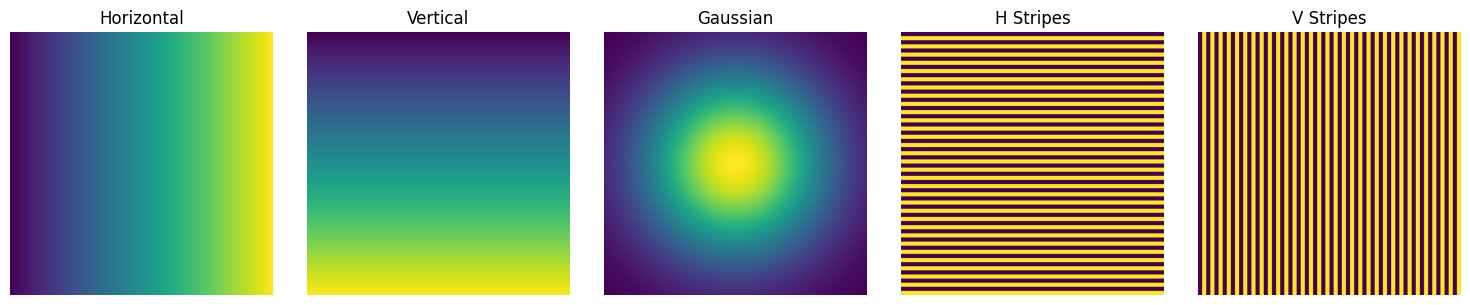

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import torch.nn.functional as F

H, W = 512, 512  # image dimensions

# Horizontal gradient
horizontal = np.linspace(0, 1, W)[None, :].repeat(H, axis=0)

# Vertical gradient
vertical = np.linspace(0, 1, H)[:, None].repeat(W, axis=1)

# Gaussian blob
x = np.linspace(-1, 1, W)
y = np.linspace(-1, 1, H)
xv, yv = np.meshgrid(x, y)
sigma = 0.5
gaussian = np.exp(-(xv**2 + yv**2) / (2 * sigma**2))

# Horizontal stripes
h_stripes = ((np.arange(H) // 8) % 2)[:, None].repeat(W, axis=1)

# Vertical stripes
v_stripes = ((np.arange(W) // 8) % 2)[None, :].repeat(H, axis=0)

# Plot all
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for ax, data, title in zip(
    axes,
    [horizontal, vertical, gaussian, h_stripes, v_stripes],
    ["Horizontal", "Vertical", "Gaussian", "H Stripes", "V Stripes"]
):
    ax.imshow(data, cmap="viridis")
    ax.set_title(title)
    ax.axis("off")

plt.tight_layout()
plt.show()


In [18]:
import torch.nn as nn
kernel_size = 5
x = torch.randn(1, 32, 32, 32)
conv = nn.Conv2d(32, 1, (kernel_size, kernel_size), stride=1, padding=0)
y=conv(x)

In [19]:
y.shape

torch.Size([1, 1, 28, 28])

In [20]:
def get_layers(model, layers_step_size=5):
    transformer_blocks = model.transformer_blocks
    num_layers = len(transformer_blocks)
    results = list(range(0, num_layers, layers_step_size))

    if (num_layers - 1) not in results:
        results.append(num_layers - 1)

    return results

get_layers(pipe.transformer, layers_step_size=5)

[0, 5, 10, 15, 19]